In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms

import math

from siren import Siren

In [2]:
img = plt.imread('planets.gif')
sidelen = 128

In [3]:
import os
from PIL import Image

num_key_frames = 10

key_frames = []

with Image.open('planets.gif') as im:
    for i in range(num_key_frames):
        im.seek(im.n_frames // num_key_frames * i)
        # im.save('{}.png'.format(i))
        key_frames.append(im.copy())

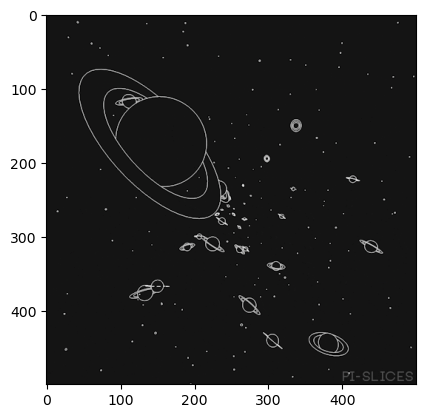

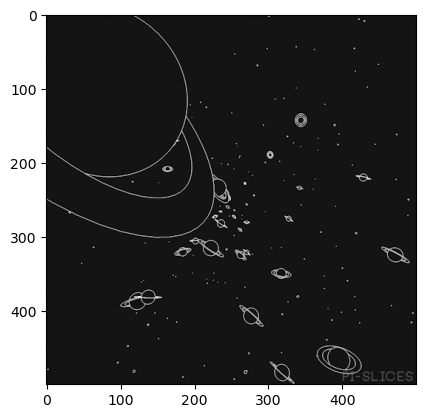

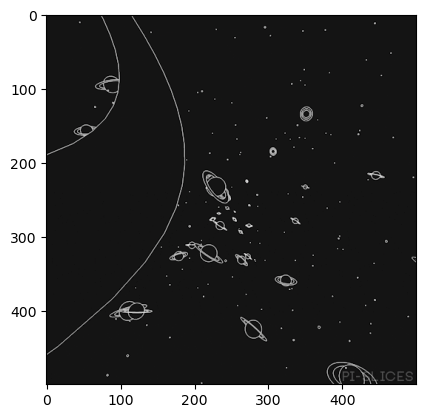

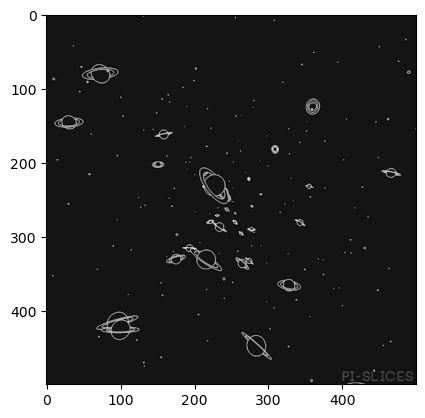

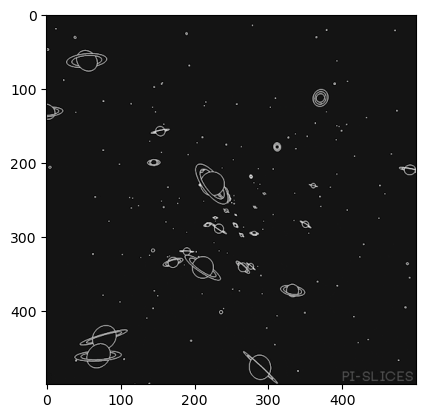

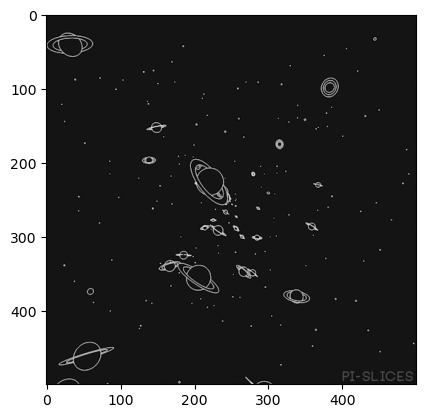

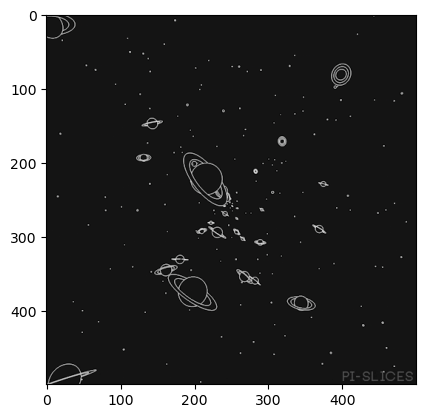

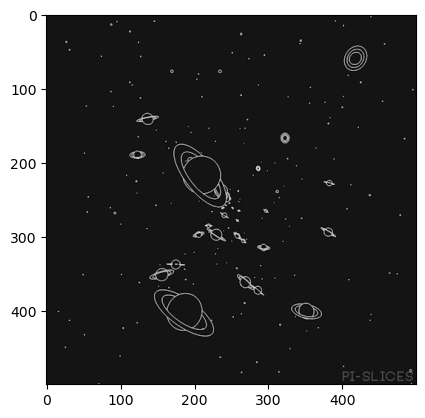

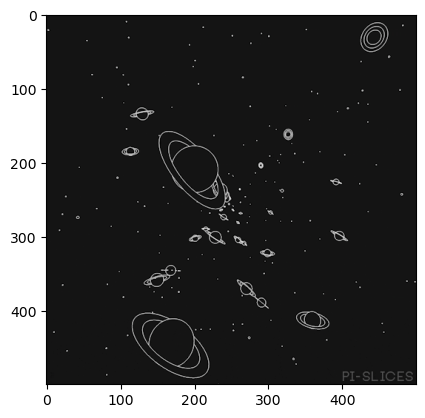

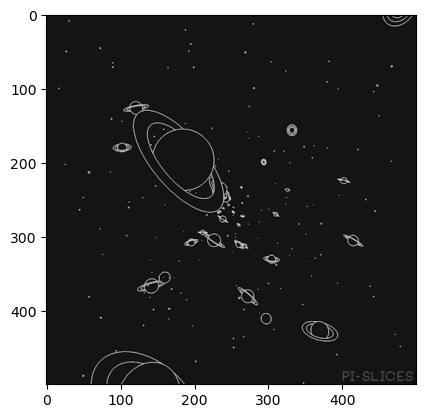

In [4]:
for i, frame in enumerate(key_frames):
    plt.imshow(frame)
    plt.show()

In [5]:
transformations = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.Resize((sidelen, sidelen)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [6]:
frame_tensors = []
for frame in key_frames:
    frame_tensor = transformations(frame)
    frame_tensors.append(frame_tensor)

img_tensor = torch.stack(frame_tensors)
img_tensor.shape

torch.Size([10, 1, 128, 128])

In [7]:
def get_coords(sidelen, dim=2, time_steps=10):
    # tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    x_dim = torch.linspace(-1, 1, steps=sidelen)
    y_dim = torch.linspace(-1, 1, steps=sidelen)
    t_dim = torch.linspace(0, 1, steps=time_steps)
    print(x_dim.shape, y_dim.shape, t_dim.shape)
    tensors = (x_dim, y_dim, t_dim)
    grid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    print(grid.shape)
    grid = grid.reshape(-1, 3)
    return grid

In [8]:
class ImageFitting(data.Dataset):
    def __init__(self, sidelength, img):
        super().__init__()
        self.pixels = img.permute(1, 2, 3, 0)
        self.pixels = self.pixels.reshape(-1, self.pixels.shape[-1])
        self.coords = get_coords(sidelength, 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [9]:
img_dataset = ImageFitting(sidelen, img_tensor)
dataloader = data.DataLoader(img_dataset, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=3, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()    

torch.Size([128]) torch.Size([128]) torch.Size([10])
torch.Size([128, 128, 10, 3])


/home/vishnu/anaconda3/envs/rico/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380481/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=3, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [10]:
total_steps = 100

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output, coords = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    optim.zero_grad()
    loss.backward()
    optim.step()

    if step % 10 == 0:
        img_output = model_output.detach().cpu().numpy()
        img_output = img_output.reshape(sidelen, sidelen)
        plt.imshow(img_output, cmap='gray')
        plt.show()

RuntimeError: The size of tensor a (163840) must match the size of tensor b (16384) at non-singleton dimension 1

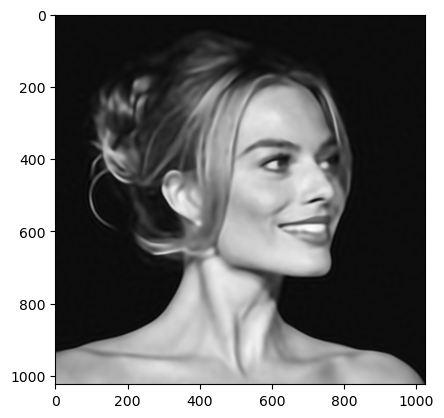

In [ ]:
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

img_output, _ = img_siren(model_input)
img_output = img_output.view(sidelen, sidelen).cpu().detach().numpy()
plt.imshow(img_output, cmap='gray')

In [ ]:
scale_factor = 2

class SuperResolution(data.Dataset):
    def __init__(self, sidelength, img):
        super().__init__()
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_coords(math.ceil(sidelength * scale_factor), 2)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        if idx > 0: raise IndexError

        return self.coords, self.pixels

In [ ]:
img_dataset = SuperResolution(sidelen, img_tensor)
supergrid_loader = data.DataLoader(img_dataset, batch_size=1, pin_memory=True, num_workers=0)

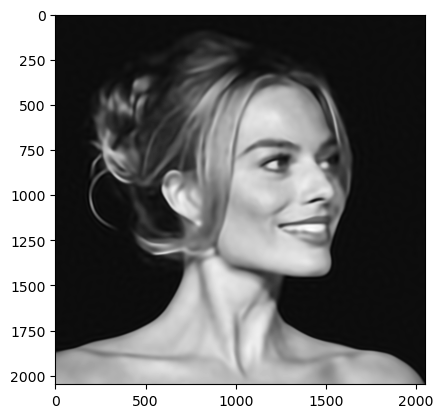

In [ ]:
model_input, ground_truth = next(iter(supergrid_loader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

img_output, _ = img_siren(model_input)
img_output = img_output.view(math.ceil(sidelen * scale_factor), math.ceil(sidelen * scale_factor)).cpu().detach().numpy()
plt.imshow(img_output, cmap='gray')
plt.savefig('superres.png', dpi = 500)